# Sentiment Analysis using word2vec and neural net
### I used [this dataset](https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech) for sentiment analysis .
### My task is recognizing speech with sexist and racist sentiment .


In [ ]:
from gensim.models import KeyedVectors
import pandas as pd 
import numpy as np 
import nltk 
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score , classification_report



nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet 
from nltk import word_tokenize, pos_tag
from collections import defaultdict

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import keras.backend as K

# I useed pre-trained [google news vectors](https://code.google.com/archive/p/word2vec/) as word2vec model .

In [ ]:
model = KeyedVectors.load_word2vec_format(open('/content/drive/My Drive/parto tech/sentiment_analysis/twitter/word2vec/word2vec.bin','rb'), binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
train = pd.read_csv('/content/drive/My Drive/parto tech/sentiment_analysis/twitter/train.csv') 

In [ ]:
def remove_at_and_hashtag (text) :
  text = text.replace('@user',' ')
  text = re.sub('[^a-zA-Z]', ' ', text)

    # Single character removal
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
  text = re.sub(r'\s+', ' ', text)
  return text.replace('#',' ')
  #TODO : use hashtags

# At cell below I developed functions to lemmatize tokens based on their POS tag using nltk library.

In [ ]:
# lemmatizing with NLTK lemmatize


def get_wordnet_pos(pos):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos.upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


lem = WordNetLemmatizer()

def my_lemmatizer (text) :
  tokens = word_tokenize(text)
  lemmatized=[]
  poses = [get_wordnet_pos(tag[0]) for tag in pos_tag(tokens)]
  for i in range (len(tokens)):
    lemma = lem.lemmatize(tokens[i],poses[i])
    lemmatized.append(lemma)
  return ' '.join(lemmatized)


In [ ]:
train['tweet'] = train['tweet'].apply(remove_at_and_hashtag)
train['tweet'] = train['tweet'].apply(my_lemmatizer)

# sentence2vec function creates a vector for each sentence based on the mean of it's words vector. If there was a word which it was not present in the pre-trained word2vec model, I've considered zero vector for that .

In [ ]:
def sentence2vec(row,w2v) :
  vector = np.zeros((1,300)) 
  words = row.split()
  count = 0 
  for word in words :
    try :
      vector += w2v[word].reshape((1,300))
      count +=1 
    except KeyError :
      continue 
  if count != 0 :
    return vector/count
  return vector

# At four cells below, I've defined x and y ,then splited them to testing and training set

In [ ]:
tweets = train.tweet.to_list()
embedded_tweets = [sentence2vec(tweet,model) for tweet in tweets]

In [ ]:
y = np.array(train.label)

In [ ]:
x_train,x_test , y_train,y_test = train_test_split(embedded_tweets,y,test_size=0.2,random_state=101)

In [ ]:
np.shape(x_train)

(25569, 1, 300)

# Because I used NN method for sentiment analysis using BERT word embedding, I prefered to train another model using neural net for word2vec word embedding for better comparison.




## at cell below i've defined NN model params.

In [ ]:
CNN1_FILTERS = 16
CNN2_FILTERS = 32
CNN3_FILTERS = 64
DNN_UNITS = 512
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 10

# Here I designed the architecture of NN

In [ ]:
text_model = tf.keras.Sequential([
              layers.Conv1D(filters=CNN1_FILTERS,kernel_size=3,input_shape=(300,1),activation="relu"),
              layers.MaxPool1D(),
              layers.Conv1D(filters=CNN2_FILTERS,kernel_size=4,activation="relu"),
              layers.MaxPool1D(),
              layers.Conv1D(filters=CNN3_FILTERS,kernel_size=6,activation="relu"),
              layers.MaxPool1D(),
              layers.Flatten(),
              layers.Dense(units=DNN_UNITS, activation=tf.nn.leaky_relu),
              layers.Dropout(DROPOUT_RATE),
              layers.Dense(units=DNN_UNITS, activation=tf.nn.leaky_relu),
              layers.Dropout(DROPOUT_RATE),
              layers.Dense(1,activation="sigmoid")

])

In [ ]:
text_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 298, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 32)           2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 73, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2176)              0

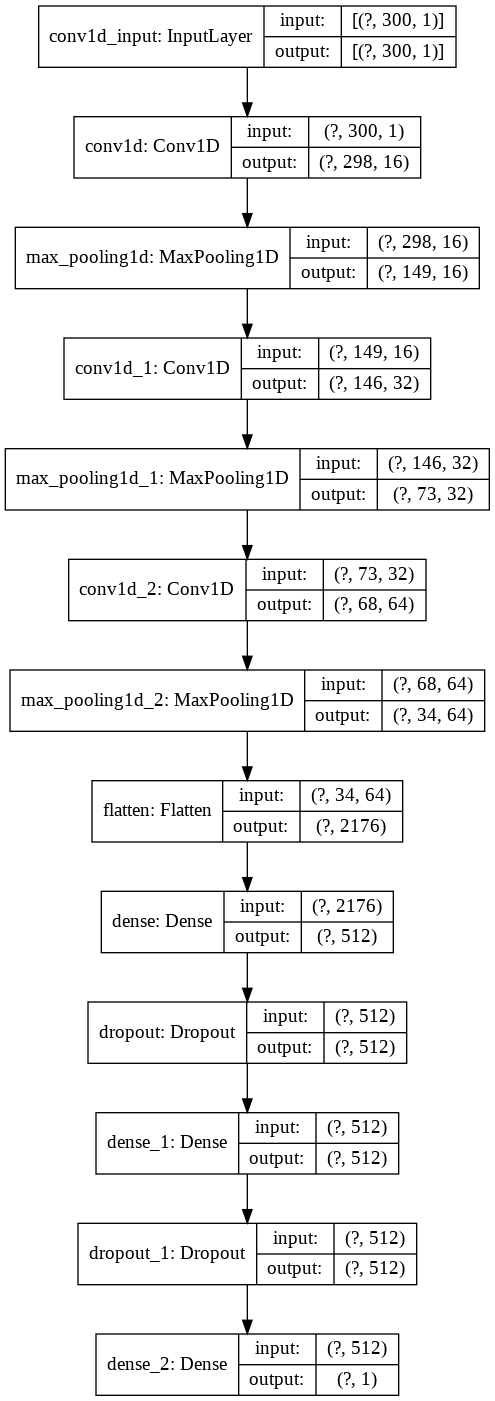

In [ ]:
plot_model(text_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Because I did not find f1-score as metrics in tensorflow.keras, I copied the code from previous versions of keras and pass function as a metric param while compiling the NN

In [ ]:
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
text_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(1e-5),
                  metrics=[get_f1])

# reshaping data for fitting into NN

In [ ]:
x_train = np.reshape(x_train,(25569,300,1))
x_test = np.reshape(x_test,(6393,300,1))
y_train = np.reshape(y_train,(25569,1))
y_test = np.reshape(y_test,(6393,1))

In [ ]:
print(np.shape(x_train)) 
print(np.shape(y_train))

print(np.shape(x_test))
print(np.shape(y_test))


(25569, 300, 1)
(25569, 1)
(6393, 300, 1)
(6393, 1)


# Because dataset is unbalanced, I created a class_weight dictionary

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=train.label)

In [ ]:
class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

{0: 0.5377187079407806, 1: 7.128010704727921}

# Fitting model and predicting new samples

In [ ]:

text_model.fit(
    x_train,
    y_train ,
    validation_split = 0.1 ,
    shuffle = True ,
    batch_size = 16,
    epochs=NB_EPOCHS,
    class_weight = class_weights
)

Epoch 1/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0269 - get_f1: 0.6500 - val_loss: 0.3347 - val_get_f1: 0.4401
Epoch 2/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0232 - get_f1: 0.6634 - val_loss: 0.3370 - val_get_f1: 0.4391
Epoch 3/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0233 - get_f1: 0.6677 - val_loss: 0.3359 - val_get_f1: 0.4445
Epoch 4/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0218 - get_f1: 0.6550 - val_loss: 0.3371 - val_get_f1: 0.4439
Epoch 5/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0169 - get_f1: 0.6729 - val_loss: 0.3378 - val_get_f1: 0.4418
Epoch 6/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0166 - get_f1: 0.6697 - val_loss: 0.3400 - val_get_f1: 0.4354
Epoch 7/10
1439/1439 [==============================] - 10s 7ms/step - loss: 0.0153 - get_f1: 0.6674 - val_loss: 0.3438 - val_get_f1: 0.4339
Epoch 8/10
14

In [ ]:
y_pred = text_model.predict_classes(x_test)

In [ ]:
print('f1-score equals to ',f1_score(y_test,y_pred),end='\n\n\n')
print(classification_report(y_test,y_pred))

# As we can see from output of above cell, performance has been **improved about 10%**


# Create Compared DataFrame for word2vec_LinearSVC, word2vec_nn and BERT models 

In [ ]:
compared_df = pd.DataFrame.from_dict({
    'model' :  ['word2vec_LinearSVC','word2vec_nn','BERT'] ,
    'preprocess_time(seconds)' : [7.65,34,18] ,
    'training_time(seconds)' : [13.28,100,3000] ,
    'predicting_time(seconds)' : [1,1,69] ,
    'f1_score(percent)' : [48.97,59.33,72] ,
    'n_samples_for_train' : [22373,25569,25569]
})
compared_df.index = ['word2vec_LinearSVC','word2vec_nn','BERT']
compared_df.to_csv('/content/drive/My Drive/parto tech/sentiment_analysis/twitter/compared_df.csv',index=False)

compared_df= pd.read_csv('/content/drive/My Drive/parto tech/sentiment_analysis/twitter/compared_df.csv')
compared_df
